In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/CIFAR-10 Models/ChristianArt.v11i.coco.zip" -d "/content/Iconart"

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 28.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.5.0+cu101

In [4]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 843 kB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=c740208369a8cda617ca3c83a775f4d20580d0b9c012b89f17c1d57210c61e16
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=dbf24c306768a5620668219bf87cb363a8ef018e16f422f3c70d141f3708c44e
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from detectron2.data import DatasetCatalog
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
import json

In [6]:
def search_image_id(image_id, images):
  for i in range(len(images)):
    if(images[i]['id'] == image_id):
      return i
  return -1

In [7]:
def get_chr_dicts(imgdir):
  json_file = imgdir + "_annotations.coco.json"
  with open(json_file) as f:
    dataset_dicts = json.load(f)
  i = 0
  while(i<len(dataset_dicts['annotations'])):
    annotations = []
    
    image_id = dataset_dicts['annotations'][i]['image_id']
    while(i<len(dataset_dicts['annotations']) and image_id == dataset_dicts['annotations'][i]['image_id']):
      dataset_dicts['annotations'][i]['bbox_mode'] = BoxMode.XYWH_ABS
      dataset_dicts['annotations'][i]['category_id'] -= 1
      annotations.append(dataset_dicts['annotations'][i])
      i+=1
      #print(i)
    image_idx = search_image_id(image_id, dataset_dicts['images'])
    dataset_dicts['images'][image_idx]['annotations'] = annotations
    dataset_dicts['images'][image_idx]['file_name'] = imgdir + dataset_dicts['images'][image_idx]['file_name']
    dataset_dicts['images'][image_idx]['image_id'] = image_id
  
  return dataset_dicts['images']

for d in ["train", "valid"]:
    DatasetCatalog.register("iconart_" + d, lambda d=d: get_chr_dicts("/content/Iconart/" + d + "/"))
    MetadataCatalog.get("iconart_" + d).set(thing_classes=["Angel", "Arrow", "Baby", "Book", "Christ", "Cross", "Crown", "Cup", "Flower", "Fruit", "Horse", "Instrument", "Key", "Lamb", "Lion", "Mary", "Pen", "Saint", "Skull", "Staff", "Sword" ])
cart_metadata = MetadataCatalog.get("iconart_train")

In [8]:
dataset_dicts = get_chr_dicts("/content/Iconart/train/")

In [9]:
dataset_dicts[916]

{'annotations': [{'area': 39032,
   'bbox': [151, 5, 136, 287],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 15,
   'id': 2862,
   'image_id': 916,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 6494,
   'bbox': [159, 41, 68, 95.5],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2,
   'id': 2863,
   'image_id': 916,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 10384.5,
   'bbox': [333, 54, 80.5, 129],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'id': 2864,
   'image_id': 916,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 9984,
   'bbox': [4, 50, 78, 128],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'id': 2865,
   'image_id': 916,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 32193,
   'bbox': [261, 185, 146, 220.5],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 17,
   'id': 2866,
   'image_id': 916,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 37562.75,
   'bbox': [7, 185, 173.5, 216.5

In [11]:
import cv2

{'id': 0, 'license': 1, 'file_name': '/content/Iconart/train/04maryma_4972_jpg.rf.7e6291dd5dbaa8a391955de68d2eb1b3.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 0, 'image_id': 0, 'category_id': 17, 'bbox': [139, 86, 188, 185], 'area': 34780, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 1, 'image_id': 0, 'category_id': 0, 'bbox': [20, 138, 85, 115.5], 'area': 9817.5, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 2, 'image_id': 0, 'category_id': 0, 'bbox': [331, 156, 82, 114.5], 'area': 9389, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 3, 'image_id': 0, 'category_id': 0, 'bbox': [285, 33, 114, 98], 'area': 11172, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 4, 'image_id': 0, 'category_id': 0, 'bbox': [69, 26, 110, 102], 'area': 11220, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1

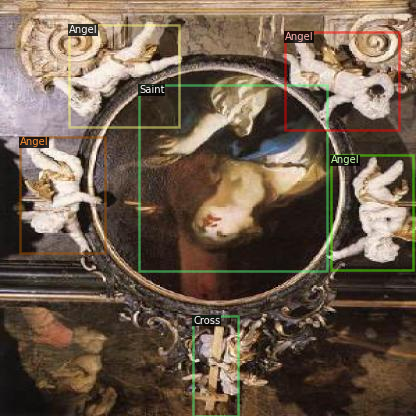

{'id': 1, 'license': 1, 'file_name': '/content/Iconart/train/stjerome_49e2_jpg.rf.7e37b3e32cf1a76e9aca5ca06ffd20b6.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 6, 'image_id': 1, 'category_id': 17, 'bbox': [13, 16, 384.5, 389], 'area': 149570.5, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 7, 'image_id': 1, 'category_id': 3, 'bbox': [246, 296, 167.5, 108], 'area': 18090, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 8, 'image_id': 1, 'category_id': 16, 'bbox': [276, 196, 117, 145.5], 'area': 17023.5, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 1}


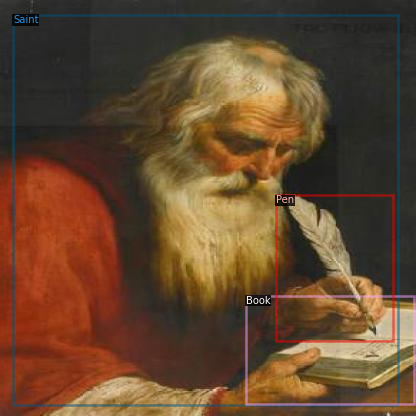

{'id': 2, 'license': 1, 'file_name': '/content/Iconart/train/mary_mag_191e_jpg.rf.80569de816bd0366129c152fa1571a0e.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 9, 'image_id': 2, 'category_id': 17, 'bbox': [13, 12, 349, 386], 'area': 134714, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 10, 'image_id': 2, 'category_id': 3, 'bbox': [0, 10, 162, 63], 'area': 10206, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 11, 'image_id': 2, 'category_id': 7, 'bbox': [365, 26, 45.5, 72], 'area': 3276, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 2}


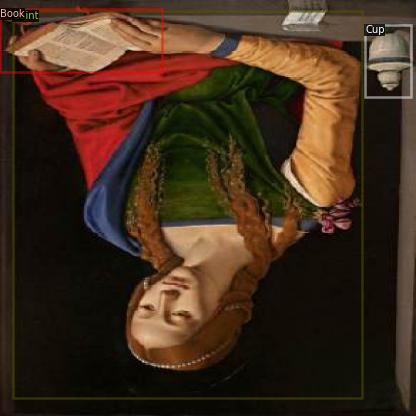

{'id': 3, 'license': 1, 'file_name': '/content/Iconart/train/predel05_004a_jpg.rf.841a98f31941017113c6c6912ba7b92c.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 12, 'image_id': 3, 'category_id': 17, 'bbox': [26, 153, 216, 244.5], 'area': 52812, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 3}


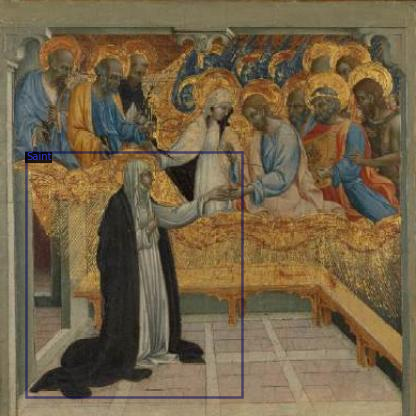

{'id': 4, 'license': 1, 'file_name': '/content/Iconart/train/DP328372_b0f9_jpg.rf.80a1cd7205b3ea60d3fb8308b347a752.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 13, 'image_id': 4, 'category_id': 15, 'bbox': [177, 101, 55, 154], 'area': 8470, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 14, 'image_id': 4, 'category_id': 2, 'bbox': [182, 136, 37, 52], 'area': 1924, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 15, 'image_id': 4, 'category_id': 4, 'bbox': [298, 157, 69.5, 104.5], 'area': 7262.75, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 16, 'image_id': 4, 'category_id': 5, 'bbox': [299, 155, 70.5, 110], 'area': 7755, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 17, 'image_id': 4, 'category_id': 17, 'bbox': [57, 158, 31.5, 107.5], 'area': 3386.25, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMo

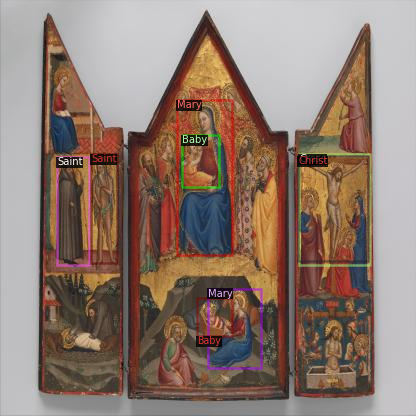

{'id': 5, 'license': 1, 'file_name': '/content/Iconart/train/ES7043_a082_jpg.rf.814d68137bf9546bb0f6a03d7b22d903.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 21, 'image_id': 5, 'category_id': 17, 'bbox': [3, 19, 409.5, 392.5], 'area': 160728.75, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 5}


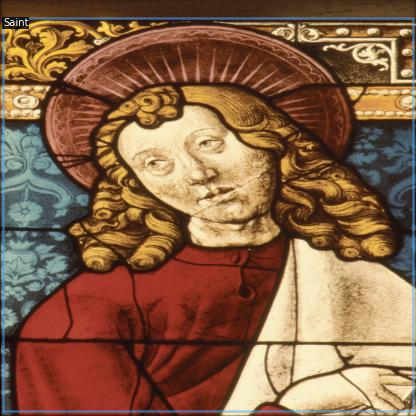

{'id': 6, 'license': 1, 'file_name': '/content/Iconart/train/1103_a675_jpg.rf.80782619edac705f395dfb3e836fe1f8.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 22, 'image_id': 6, 'category_id': 17, 'bbox': [58, 66, 338.5, 349.5], 'area': 118305.75, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 23, 'image_id': 6, 'category_id': 19, 'bbox': [40, 79, 338.5, 254.5], 'area': 86148.25, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 24, 'image_id': 6, 'category_id': 3, 'bbox': [272, 157, 137, 68], 'area': 9316, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 6}


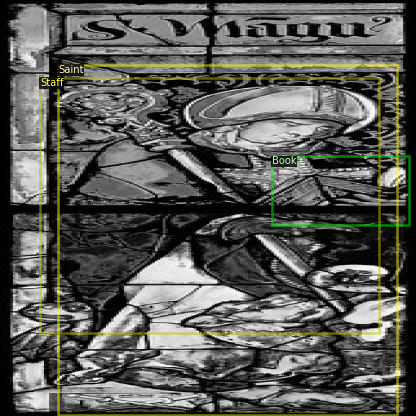

{'id': 7, 'license': 1, 'file_name': '/content/Iconart/train/default_0f5e_jpg.rf.7f7c0e0ab7039db0761edf1c14cf6a00.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 25, 'image_id': 7, 'category_id': 17, 'bbox': [92, 48, 289, 307], 'area': 88723, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 7}


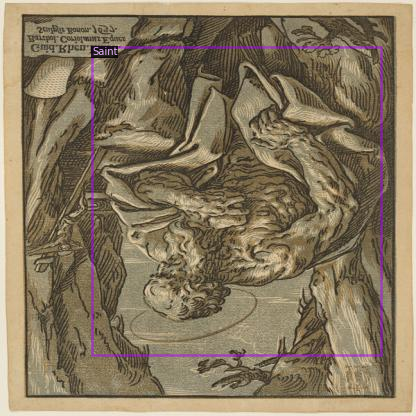

{'id': 8, 'license': 1, 'file_name': '/content/Iconart/train/1804grec_a289_jpg.rf.822671f9d6377fb9d79623efdade757b.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 26, 'image_id': 8, 'category_id': 17, 'bbox': [7, 0, 391, 403], 'area': 157573, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 27, 'image_id': 8, 'category_id': 7, 'bbox': [340, 2, 74.5, 173.5], 'area': 12925.75, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 8}


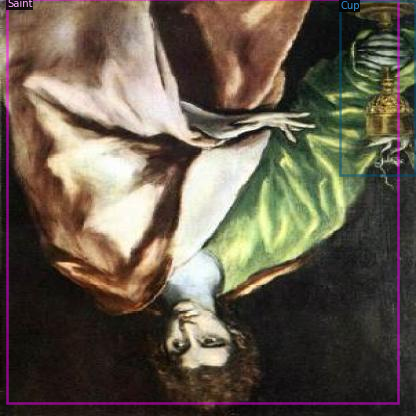

{'id': 9, 'license': 1, 'file_name': '/content/Iconart/train/cdi32-24-15_9610_jpg.rf.832882090b3dc949e458d1748ab832b0.jpg', 'height': 416, 'width': 416, 'date_captured': '2022-08-11T10:57:34+00:00', 'annotations': [{'id': 28, 'image_id': 9, 'category_id': 17, 'bbox': [89, 42, 185, 332], 'area': 61420, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 29, 'image_id': 9, 'category_id': 15, 'bbox': [118, 83, 106, 182], 'area': 19292, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 30, 'image_id': 9, 'category_id': 2, 'bbox': [150, 107, 57, 104.5], 'area': 5956.5, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'id': 31, 'image_id': 9, 'category_id': 6, 'bbox': [119, 94, 47.5, 15.5], 'area': 736.25, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 9}


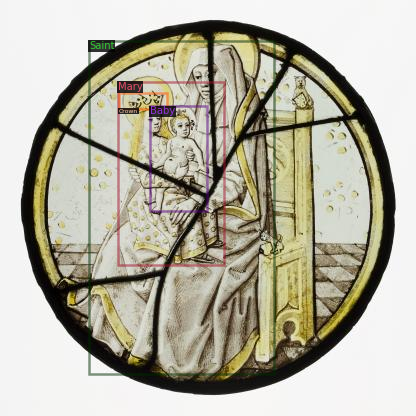

In [12]:
for i in range(10):
    print(dataset_dicts[i])
    img = cv2.imread(dataset_dicts[i]["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cart_metadata)
    vis = visualizer.draw_dataset_dict(dataset_dicts[i])
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("iconart_train",)
cfg.DATASETS.TEST = ("iconart_valid",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 7*500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [15]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/11 11:04:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:05, 31.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[08/11 11:04:22 d2.engine.train_loop]: Starting training from iteration 0
[08/11 11:04:34 d2.utils.events]:  eta: 0:36:22  iter: 19  total_loss: 3.262  loss_cls: 2.614  loss_box_reg: 0.493  loss_rpn_cls: 0.036  loss_rpn_loc: 0.022  time: 0.6344  data_time: 0.0339  lr: 0.000250  max_mem: 3166M
[08/11 11:04:47 d2.utils.events]:  eta: 0:36:26  iter: 39  total_loss: 1.305  loss_cls: 0.743  loss_box_reg: 0.525  loss_rpn_cls: 0.039  loss_rpn_loc: 0.024  time: 0.6354  data_time: 0.0161  lr: 0.000500  max_mem: 3166M
[08/11 11:05:00 d2.utils.events]:  eta: 0:36:31  iter: 59  total_loss: 1.302  loss_cls: 0.679  loss_box_reg: 0.542  loss_rpn_cls: 0.051  loss_rpn_loc: 0.026  time: 0.6396  data_time: 0.0127  lr: 0.000749  max_mem: 3166M
[08/11 11:05:13 d2.utils.events]:  eta: 0:36:22  iter: 79  total_loss: 1.236  loss_cls: 0.656  loss_box_reg: 0.528  loss_rpn_cls: 0.041  loss_rpn_loc: 0.019  time: 0.6400  data_time: 0.0166  lr: 0.000999  max_mem: 3166M
[08/11 11:05:26 d2.utils.events]:  eta: 0:36:0

In [24]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("iconart_valid", )

predictor = DefaultPredictor(cfg)
count = 0
dataset_dicts = get_chr_dicts("/content/Iconart/valid/")
for d in random.sample(dataset_dicts, 110):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cart_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2.imwrite("images/example%d.jpg" % count, v.get_image()[:, :, ::-1])
    count+=1


In [ ]:
cfg.DATASETS.TEST

[{'date_captured': '2022-07-26T01:04:30+00:00',
  'file_name': '/content/Iconart/valid/christ_c_9f57_jpg.rf.1218c76cd8139b246301d1775d449d42.jpg',
  'height': 416,
  'id': 0,
  'image': tensor([[[ 23,  29,  41,  ...,  58,  61,  62],
           [ 22,  28,  39,  ...,  55,  57,  58],
           [ 20,  25,  35,  ...,  48,  51,  52],
           ...,
           [149, 150, 151,  ..., 200, 206, 209],
           [142, 143, 144,  ..., 206, 210, 212],
           [139, 140, 141,  ..., 210, 213, 214]],
  
          [[ 42,  48,  60,  ...,  78,  81,  82],
           [ 41,  47,  58,  ...,  75,  77,  78],
           [ 39,  44,  54,  ...,  68,  71,  72],
           ...,
           [194, 195, 196,  ..., 214, 220, 223],
           [188, 188, 189,  ..., 220, 224, 226],
           [185, 185, 186,  ..., 224, 227, 228]],
  
          [[ 69,  75,  87,  ..., 103, 106, 107],
           [ 68,  74,  85,  ..., 100, 102, 103],
           [ 66,  71,  81,  ...,  93,  96,  97],
           ...,
           [228, 229, 230

In [20]:
dataset = DatasetCatalog.get("iconart_valid")

In [ ]:
next(iter(val_loader))

[{'date_captured': '2022-07-26T01:04:30+00:00',
  'file_name': '/content/Iconart/valid/christ_c_9f57_jpg.rf.1218c76cd8139b246301d1775d449d42.jpg',
  'height': 416,
  'id': 0,
  'image': tensor([[[ 23,  29,  41,  ...,  58,  61,  62],
           [ 22,  28,  39,  ...,  55,  57,  58],
           [ 20,  25,  35,  ...,  48,  51,  52],
           ...,
           [149, 150, 151,  ..., 200, 206, 209],
           [142, 143, 144,  ..., 206, 210, 212],
           [139, 140, 141,  ..., 210, 213, 214]],
  
          [[ 42,  48,  60,  ...,  78,  81,  82],
           [ 41,  47,  58,  ...,  75,  77,  78],
           [ 39,  44,  54,  ...,  68,  71,  72],
           ...,
           [194, 195, 196,  ..., 214, 220, 223],
           [188, 188, 189,  ..., 220, 224, 226],
           [185, 185, 186,  ..., 224, 227, 228]],
  
          [[ 69,  75,  87,  ..., 103, 106, 107],
           [ 68,  74,  85,  ..., 100, 102, 103],
           [ 66,  71,  81,  ...,  93,  96,  97],
           ...,
           [228, 229, 230

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("iconart_valid", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "iconart_valid")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [08/11 08:34:07 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'iconart_valid'. Trying to convert it to COCO format ...
[08/11 08:34:07 d2.data.datasets.coco]: Converting annotations of dataset 'iconart_valid' to COCO format ...)
[08/11 08:34:07 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/11 08:34:07 d2.data.datasets.coco]: Conversion finished, #images: 99, #annotations: 328
[08/11 08:34:07 d2.data.datasets.coco]: Caching COCO format annotations at '/output/iconart_valid_coco_format.json' ...
[08/11 08:34:07 d2.data.build]: Distribution of instances among all 21 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Angel    | 39           |   Arrow    | 16           |    Baby    | 24           |
|    Book    | 31           |   Christ   | 7            |   Cross    | 10           |
|   Crown

OrderedDict([('bbox',
              {'AP': 8.940287072016044,
               'AP-Angel': 4.663366336633663,
               'AP-Arrow': 4.752475247524751,
               'AP-Baby': 26.16886304015017,
               'AP-Book': 8.076732673267326,
               'AP-Christ': 18.81188118811881,
               'AP-Cross': 21.584158415841586,
               'AP-Crown': 3.5643564356435626,
               'AP-Cup': 19.356435643564357,
               'AP-Flower': 0.0,
               'AP-Fruit': 0.0,
               'AP-Horse': 0.0,
               'AP-Instrument': nan,
               'AP-Key': nan,
               'AP-Lamb': 0.0,
               'AP-Lion': 6.7326732673267315,
               'AP-Mary': 19.934921123691318,
               'AP-Pen': 0.0,
               'AP-Saint': 28.496818719314852,
               'AP-Skull': 7.722772277227722,
               'AP-Staff': 0.0,
               'AP-Sword': 0.0,
               'AP50': 18.61842115261946,
               'AP75': 6.234589613591692,
            

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set threshold for this model
#cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/CIFAR-10 Models", "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
predictor = DefaultPredictor(cfg)

AssertionError: ignored

In [25]:
!zip -r images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/example67.jpg (deflated 0%)
  adding: content/images/example54.jpg (deflated 0%)
  adding: content/images/example56.jpg (deflated 1%)
  adding: content/images/example103.jpg (deflated 1%)
  adding: content/images/example70.jpg (deflated 0%)
  adding: content/images/example33.jpg (deflated 1%)
  adding: content/images/example102.jpg (deflated 1%)
  adding: content/images/example31.jpg (deflated 0%)
  adding: content/images/example85.jpg (deflated 0%)
  adding: content/images/example64.jpg (deflated 1%)
  adding: content/images/example8.jpg (deflated 0%)
  adding: content/images/example43.jpg (deflated 1%)
  adding: content/images/example0.jpg (deflated 0%)
  adding: content/images/example101.jpg (deflated 0%)
  adding: content/images/example18.jpg (deflated 1%)
  adding: content/images/example83.jpg (deflated 1%)
  adding: content/images/example47.jpg (deflated 0%)
  adding: content/images/example30.jpg (deflated 1%)
  addin